# Simulating the Heston Process

## Introduction
In today's post, I will examine a few issues related to numerical simulation of the Heston model.
As a quick reminder, the Heston process is a stochastic volatility model defined by the
following sde:

$$
\begin{align}
dS_t =& (r-d) S_t dt + \sqrt{V_t} S_t dW^s_t \\
dV_t =& \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW^\upsilon_t \\
dW^s_t dW^\upsilon_t =& \rho dt
\end{align}
$$

for asset price $S_t$. $dW_t^s$ and $dW_t^{\nu}$ are Wiener processes with correlation $\rho$.  As usual, $r$ and $d$ are the risk free and dividend rates respectively.

The Heston model is an excellent benchmarking model due to the suprising fact that
that it's probability distribution function (pdf) has a closed formed expression.  It's a one
of five such processes in 1 or 2 dimensions [PHL](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=773568).  With the closed form pdf, we can easily compare the performance of the Heston model's numerical simulation by
comparing PV's of a Monte Carlo pricer with an analytic pricer.


To carry out a numerical simulation we first need to choose a discretization scheme. That is, we need to approximate the infinitesimal diffusion process with a finite scheme to be used in the simulation code.  Any such scheme may potentially introduce bias into the simulation that could alter the realized moments of the pdf.

The simplest possible scheme is a first order expansion, i.e. an Euler Mayorana (or just ''Euler'') scheme.  Transforming to $\ln S$ and discretizing $t$ to step size $\Delta$ gives

$$
\ln S(t + \Delta) = \ln S(t) + \left(r - d - \frac{1}{2}V(t)\right)\Delta +\sqrt{V(t)} Z_S\sqrt{\Delta}
$$
$$
V(t + \Delta) = V(t) + \kappa\left(\theta - V(t)\right)\Delta + \sigma \sqrt{V(t)} Z_V \sqrt{\Delta}
$$


However, it turns out that this scheme does introduce bias.  Furthermore, in this scheme it's possible to drive the variance process to negative values, which is outside the range of the pdf and causes the simulation to stop as $\sqrt{V}$ becomes imaginary.

One immediate fix to this problem is the floor V at 0, giving the so called "Truncated" scheme.
Other schemes are based on higher order expansions of the sde or utilizing the closed form
expression for the pdf. These are documented extensively in the literature [Anderson](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=946405).  We list some of the schemes below

1. Euler Mayorana
2. Truncated
3. Quadratic Exponential 
4. Broadie Kaya (Exact Simulation)

Broadie Kaya is based off direct sampling from the pdf but is rather difficult to implement numerically.  The Quadratic Exponential (developed in [Anderson](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=946405)) approximates the pdf using simplified functions and moment matching.  The pdf for high and low values of the variance are matched against two different functions and threshold is implemented to switch between the two functions during a diffusion.  This technique allows one to minimize variance while also easing the numerical implementation.  As such, this scheme it is often the preferred scheme for Heston simulations.    

## QuantLib Implementation

QuantLib includes several of these discretization schemes in their
Heston Process class.  Let's see what a simulation looks like.

Quick note: Although the HestonProcess class is available through the SWIG bindings,
it does not expose the discretizations argument.  Instead, we use [PyQL](https://github.com/enthought/pyql), 
which has all the discretizations available.

In [1]:
from quantlib.processes.heston_process import *
from quantlib.quotes import SimpleQuote
from quantlib.settings import Settings
from quantlib.termstructures.yields.flat_forward import FlatForward
from quantlib.time.api import today, TARGET, ActualActual, Date, Period, Years
from quantlib.models.equity.heston_model import (HestonModel,
                                                 HestonModelHelper)
from quantlib.pricingengines.api import (AnalyticHestonEngine)
from quantlib.pricingengines.vanilla.mceuropeanhestonengine import MCEuropeanHestonEngine
from quantlib.instruments.api import (PlainVanillaPayoff,
                                      EuropeanExercise,
                                      VanillaOption,
                                      EuropeanOption)

Defining the Heston Process
-------------------------------

In [2]:
def flat_rate(forward, daycounter):
    return FlatForward(
        forward = forward,
        settlement_days = 0,
        calendar = TARGET(),
        daycounter = daycounter
    )

settings = Settings.instance()
settlement_date = today()
settings.evaluation_date = settlement_date

day_counter = ActualActual()
interest_rate = 0.7
dividend_yield = 0.4

risk_free_ts = flat_rate(interest_rate, day_counter)
dividend_ts = flat_rate(dividend_yield, day_counter)

maturity = Period(10, Years)
exercise_date = settlement_date + maturity

# spot
s0 = SimpleQuote(100.0)

# Available descritizations
#PARTIALTRUNCATION 
#FULLTRUNCATION 
#REFLECTION 
#NONCENTRALCHISQUAREVARIANCE 
#QUADRATICEXPONENTIAL
#QUADRATICEXPONENTIALMARTINGALE
#BROADIEKAYAEXACTSCHEMELOBATTO
#BROADIEKAYAEXACTSCHEMELAGUERRE
#BROADIEKAYAEXACTSCHEMETRAPEZOIDAL 

# Heston Model params
v0 = 0.05
kappa = 5.0
theta = 0.05
sigma = 1.0e-4
rho = -0.5

def gen_process(desc):
    process = HestonProcess(risk_free_ts,
                            dividend_ts,
                            s0,
                            v0,
                            kappa,
                            theta,
                            sigma,
                            rho,
                            desc)
    return process

processes = {"REFLECTION" : gen_process(REFLECTION), 
             "PARTIALTRUNCATION" : gen_process(PARTIALTRUNCATION),
             "QUADRATICEXPONENTIAL" : gen_process(QUADRATICEXPONENTIAL),
             "QUADRATICEXPONENTIALMARTINGALE" : gen_process(QUADRATICEXPONENTIALMARTINGALE),
}

## Visualizing the Simulation

Note: The *simulate* function is not part of Quantlib. It has been added to the pyQL interface (see folder quantlib/sim). 

In [3]:
from quantlib.sim.simulate import simulate_process
from quantlib.time_grid import TimeGrid

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

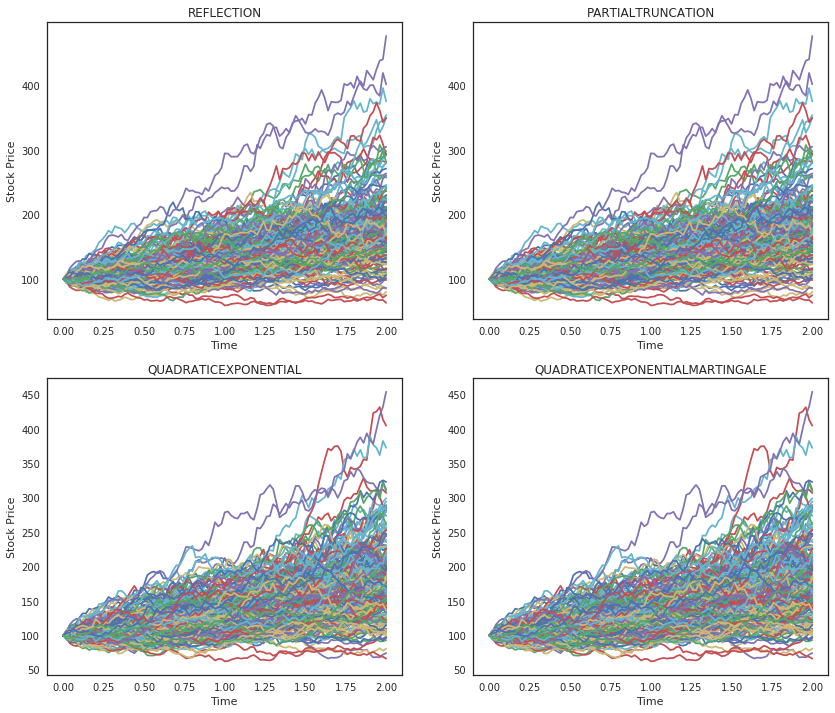

In [5]:
# simulate and plot Heston paths
paths = 200
steps = 100
horizon = 2
seed = 154

grid = TimeGrid(horizon, steps)

fig, axs = plt.subplots(figsize=(14, 12), nrows=2, ncols=2)
flat_axs = axs.reshape(-1) 

for i, key in enumerate(processes.keys()):
    flat_axs[i].plot(list(grid), simulate_process(processes[key], paths, grid, seed))
    flat_axs[i].set_xlabel('Time')
    flat_axs[i].set_ylabel('Stock Price')
    flat_axs[i].set_title('%s' % key)


Let's look at of the diffusions in detail, for example the evolution of the Heston process using Partial Truncation looks like this

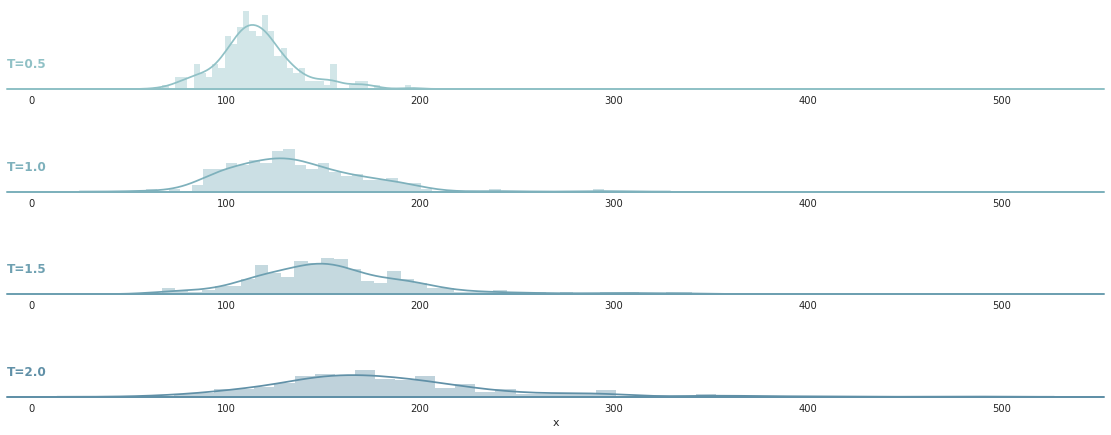

In [16]:
res = simulate_process(processes["PARTIALTRUNCATION"], paths, grid, seed)
x = res[[25,50,75,100],:].reshape(4*paths)

g = np.repeat(["T=0.5","T=1.0","T=1.5","T=2.0"], paths)
df = pd.DataFrame(dict(x=x, g=g))

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=10, size=1.6, palette=pal)

g.map(sns.distplot, "x", bins=40, kde=True, rug=False)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .3, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")
g.fig.subplots_adjust(hspace=.25)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

## Comparing the PV's of different engines

To examine the performance of the numerical schemes, we simply compare the PV's
the same Call Option priced with an analytic and Monte Carlo engine.  The results
for different time steps and schemes are given in the table below

In [34]:
# Build a Call Option 
payoff = PlainVanillaPayoff('Call', 105)
exercise = EuropeanExercise(exercise_date)
option = EuropeanOption(payoff, exercise)

results = {"REFLECTION" : [],
           "PARTIALTRUNCATION" : [],
           "QUADRATICEXPONENTIAL" : [],
           "QUADRATICEXPONENTIALMARTINGALE" : [],
}

# steps per year
steps = [1, 4, 8, 16]

for k, v in processes.items():
    for step in steps:
        mc_engine = MCEuropeanHestonEngine(v,
                                           steps_per_year=step,
                                           required_samples=500,
                                           seed=1234,
                                           )
        option.set_pricing_engine(mc_engine)
        results[k].append((np.around(option.npv, 5), np.around(option.error_estimate, 5)))

        
results["time steps per year"] = steps
results_df = pd.DataFrame(data = results)
cols = results_df.columns.tolist()
cols = cols[-1:] + cols[-2:-1] +  cols[:-2]
results_df = results_df[cols] 

In [35]:
results_df

,time steps per year,REFLECTION,PARTIALTRUNCATION,QUADRATICEXPONENTIAL,QUADRATICEXPONENTIALMARTINGALE
0,1,"(1.64404, 0.05392)","(1.64447, 0.06608)","(1.98966, 0.04768)","(1.80227, 0.03563)"
1,4,"(1.74109, 0.03607)","(1.74109, 0.03607)","(1.77399, 0.03692)","(1.75864, 0.0351)"
2,8,"(1.71144, 0.02744)","(1.71144, 0.02744)","(1.70905, 0.02727)","(1.70581, 0.02687)"
3,16,"(1.71527, 0.02811)","(1.71527, 0.02811)","(1.73049, 0.02829)","(1.72956, 0.02818)"


## Conclusion

As we saw, there are many ways to simulate the Heston model, each with strengths and
weaknesses with regards to bias/accuracy and runtime performance.  In general, the Quadratic Exponential scheme performed better than Euler-type schemes, especially for simulations with fewer time steps per year.

In a future post, I will visit the local stochastic volatility version of the Heston model to see how it's simulation
works.  


## Is there a better way?

If you take a look at the HestonProcess class file in QuantLib you will see that it,
for each discretization, there is a different diffusion implementation.
The user chooses the discretization from an enumerated list. The downside to this approach is that
, in addition to creating bloated code, the list is always finite.
 What happens when someone wants to create a new discretization scheme that's not on the list? She has to add the diffusion implementation directly into the HestonProcess class.  

A better approach might be to allow the user to build her own discretization in
Python and then "compile-down" to C++ in the similar way to how the finite
difference stencils are created in Devito [see my earlier post]
This may just be hopeful speculation on my part :).  Until next time.